In [1]:
from vosk import Model, KaldiRecognizer, SetLogLevel
from typing import List, Set, Any, Dict, Tuple, TypedDict, cast
import sys
import os, json
import wave
import subprocess
from pydub import AudioSegment
SetLogLevel(0)

import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display

In [3]:
%load_ext nb_mypy 


Version 1.0.2


# Declare dict structure

In [9]:
class WordInfo(TypedDict):
    conf: float #confidence for specific word (from 0 to 1)
    end: float #end time for spoken word in sec
    start: float #start time of spoken word in sec
    word: str #detected word
        
class VoskResult(TypedDict):
    result: List[WordInfo] #list of statistics for each word
    text: str #spoken text

class WordCount(TypedDict):
    word: str #word to be counted
    count: int #count of spoken word

class WordOccurrence(TypedDict):
    word: str #word that occurred in speech
    occurrences: List[Tuple[float, float]] #start and end time in sec for spoken word

# Declare constants

In [4]:
AUDIO_PATH = "audio/" #path to audio speech files
SEGMENTED_PATH = "segmented audio/" #path to segmented audio speech files from pydub
RESULTS_PATH = "results/" #stores vosk outputs in this folder as json-files

# librosa constants
SAMPLING_RATE = 16000
FRAME_SIZE = 512
HOP_LENGTH = 256

In [60]:
def vosk_output(audio_path: str) -> None:
    if not os.path.exists("model"):
        print ("Please download the model from https://alphacephei.com/vosk/models and unpack as 'model' in the current folder.")
        exit (1)

    sample_rate=16000
    print("Wait for vosk to analyze the audio file(s)...")
    
    for audio_file in os.listdir(audio_path):
        model = Model("model")
        rec = KaldiRecognizer(model, sample_rate)
        rec.SetWords(True)
        
        print(f"Analyzing audio file: {audio_file}")
        # converts audio file to appropriate format (ffmpeg needs to be installed)
        process = subprocess.Popen(['ffmpeg', '-loglevel', 'quiet', '-i',
                                    f"{audio_path}{audio_file}",
                                    '-ar', str(sample_rate) , '-ac', '1', '-f', 's16le', '-'],
                                    stdout=subprocess.PIPE)

        json_array = []

        while True:
            data = process.stdout.read(4000)
            if len(data) == 0:
                break
            if rec.AcceptWaveform(data):
                res = json.loads(rec.Result())
                if 'result' in res:
                    json_array.append(VoskResult(result=[WordInfo(**info) for info in res['result']] , text=res['text']))
            else:
                pass

        final = json.loads(rec.FinalResult())
        if 'result' in final:
            json_array.append(VoskResult(result=[WordInfo(**info) for info in final['result']] , text=final['text']))

        with open(f'{RESULTS_PATH}{audio_file[:-4]}_results.json', 'w') as json_res:
            json.dump(json_array, json_res)
            print("Created vosk results file!")
    print("Vosk finished audio file processing!")
            
vosk_output(AUDIO_PATH)

<cell>24: error: Item "None" of "Optional[IO[bytes]]" has no attribute "read"
<cell>30: error: Expected keyword arguments, {...}, or dict(...) in TypedDict constructor
<cell>36: error: Expected keyword arguments, {...}, or dict(...) in TypedDict constructor


Wait for vosk to analyze the audio file(s)...
Analyzing audio file: 345_AUDIO_SLICED_30.0s.wav
Created vosk results file!
Analyzing audio file: 346_AUDIO_SLICED_30.0s.wav
Created vosk results file!
Analyzing audio file: 484_AUDIO_SLICED_30.0s.wav
Created vosk results file!
Analyzing audio file: 492_AUDIO_SLICED_30.0s.wav
Created vosk results file!
Vosk finished audio file processing!


In [29]:
def word_statistics(path_to_json: str) -> List[WordCount]:
    """
    returns a dict that contains every spoken word and its count.
    """
    counts = []  # type: List[WordCount]

    with open(path_to_json, 'r') as json_res:
        json_array = json.load(json_res)
    for item in json_array:
        if 'result' in item:
            for word_stat in item['result']:
                found_word = False
                for count in counts:
                    if word_stat['word'] == count.get('word'):
                        found_word = True
                        count['count'] += 1
                        break
                if found_word == False:
                    counts.append(WordCount(word=word_stat['word'], count=1))
                  
    # sort by word count
    sorted_counts = sorted(counts, key=lambda d: d['count'], reverse=True)

    return sorted_counts
                    
def get_word_occurrences(word_stat: List[WordCount], path_to_json: str) -> List[WordOccurrence]:
    """
    returns a list of the occurrences (in sec) of all spoken words. First item in list is the most spoken word.
    """
    occurrences: List[WordOccurrence] = [] 
    
    with open(path_to_json, 'r') as json_res:
        json_array = json.load(json_res)
    for stat in word_stat:
        occurrences.append({'word': stat['word'], 'occurrences': []})
        for result in json_array:
            for occurrence in result['result']:
                if occurrence['word'] == stat['word']:
                    occurrences[len(occurrences) - 1]['occurrences'].append((occurrence['start'], occurrence['end']))
    return occurrences
    

[{'word': 'like', 'occurrences': [(1.71, 1.89), (7.35, 7.56), (11.91, 12.3), (14.4, 14.58), (15.21, 15.39), (21.27, 21.54), (23.406339, 23.67), (24.36, 24.9), (25.05, 25.26), (27.36, 27.57)]}, {'word': 'i', 'occurrences': [(0.0, 0.09), (0.601067, 0.69), (5.19, 5.28), (6.93, 7.05), (11.31, 11.91), (14.31, 14.4), (18.66, 18.75), (20.67, 21.27), (24.96, 25.05)]}, {'word': 'to', 'occurrences': [(6.0, 6.09), (7.56, 8.04), (8.79, 8.88), (12.3, 12.42), (12.6, 12.69), (14.58, 14.7), (15.39, 15.48), (21.54, 21.69), (25.26, 25.32)]}, {'word': 'go', 'occurrences': [(12.42, 12.6), (14.7, 14.82), (15.48, 15.69), (16.98, 17.19), (17.82, 18.0), (21.69, 22.44)]}, {'word': 'and', 'occurrences': [(6.84, 6.93), (9.24, 9.42), (19.62, 20.16), (22.5, 23.07)]}, {'word': 'the', 'occurrences': [(2.22, 2.28), (12.69, 12.81), (27.81, 27.9)]}, {'word': 'fun', 'occurrences': [(10.83, 11.25), (14.01, 14.31), (26.58, 26.97)]}, {'word': 'of', 'occurrences': [(1.23, 1.35), (13.92, 14.01)]}, {'word': 'but', 'occurrence

# Get word stats for multiple audio files

In [64]:
for vosk_result in os.listdir(RESULTS_PATH):
    word_stat = word_statistics(f"{RESULTS_PATH}{vosk_result}")
    print("------------------------------------")
    print(word_stat)
#word_occurrences = get_word_occurrences(word_stat, "results/345_AUDIO_SLICED_30.0s_results.json")

------------------------------------
[{'word': 'like', 'count': 10}, {'word': 'i', 'count': 9}, {'word': 'to', 'count': 9}, {'word': 'go', 'count': 6}, {'word': 'and', 'count': 4}, {'word': 'fun', 'count': 3}, {'word': 'of', 'count': 2}, {'word': 'the', 'count': 2}, {'word': 'but', 'count': 2}, {'word': 'a', 'count': 2}, {'word': 'shopping', 'count': 2}, {'word': 'play', 'count': 2}, {'word': 'games', 'count': 2}, {'word': 'smile', 'count': 1}, {'word': 'guess', 'count': 1}, {'word': 'it', 'count': 1}, {'word': 'kind', 'count': 1}, {'word': 'hides', 'count': 1}, {'word': "what's", 'count': 1}, {'word': 'on', 'count': 1}, {'word': 'inside', 'count': 1}, {'word': 'you', 'count': 1}, {'word': 'know', 'count': 1}, {'word': "i'm", 'count': 1}, {'word': 'pretty', 'count': 1}, {'word': 'depressed', 'count': 1}, {'word': 'yo', 'count': 1}, {'word': 'just', 'count': 1}, {'word': 'try', 'count': 1}, {'word': 'keep', 'count': 1}, {'word': 'smiling', 'count': 1}, {'word': 'always', 'count': 1}, {'

In [41]:
# def segment_words_from_audio(audio_extraction_path: str, path_to_audio_file: str, word_occurrence: WordOccurrence):
#     audio = AudioSegment.from_wav(path_to_audio_file)
#     occurrences = word_occurrence['occurrences']
#     segment = audio[occurrences[0][0] * 1000 : occurrences[0][1] * 1000]
#     for i in range(1, len(occurrences)):
#         segment = segment + audio[occurrences[i][0] * 1000 : occurrences[i][1] * 1000]
#     parts = path_to_audio_file[:-4].split('/')
#     file_name = parts[len(parts) - 1]
#     segment.export(f"{audio_extraction_path}{file_name}_word-{word_occurrence['word'].upper()}.wav", format='wav')

# segment_words_from_audio(EXTRACTED_AUDIO_PATH, f"{AUDIO_PATH}345_AUDIO_SLICED_30.0s.wav", word_occurrences[0])

<cell>4: error: Slice index must be an integer or None
<cell>6: error: Slice index must be an integer or None


In [78]:
def segment_word_from_audio(audio_extraction_path: str, path_to_audio_files: str, word: str):
    for result_file in os.listdir(RESULTS_PATH):
        # get word stats
        word_stat = word_statistics(f"{RESULTS_PATH}{result_file}")
        # get occurrences
        occurrences = get_word_occurrences(word_stat, f"{RESULTS_PATH}{result_file}")
        # get occurrence for word
        word_occurrence = [occurrence for occurrence in occurrences if occurrence['word'] == word][0]
        # extract word from audio file
        audio_file_name = result_file.split("_results")[0] + ".wav"
        audio = AudioSegment.from_wav(f"{AUDIO_PATH}{audio_file_name}")
        occurrences = word_occurrence['occurrences']
        segment = audio[occurrences[0][0] * 1000 : occurrences[0][1] * 1000]
        for i in range(1, len(occurrences)):
            segment = segment + audio[occurrences[i][0] * 1000 : occurrences[i][1] * 1000]
        segment.export(f"{audio_extraction_path}{audio_file_name}_word-{word_occurrence['word'].upper()}.wav", format='wav')
    

<cell>13: error: Slice index must be an integer or None
<cell>15: error: Slice index must be an integer or None


In [79]:
segment_word_from_audio(SEGMENTED_PATH, AUDIO_PATH, 'and')

# F0 contour

345_AUDIO_SLICED_30.0s.wav_word-AND.wav
346_AUDIO_SLICED_30.0s.wav_word-AND.wav
484_AUDIO_SLICED_30.0s.wav_word-AND.wav
492_AUDIO_SLICED_30.0s.wav_word-AND.wav


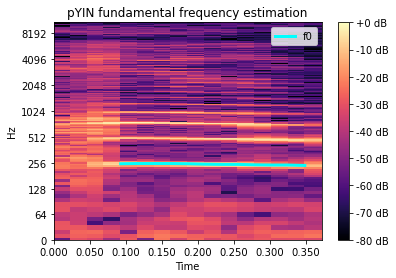

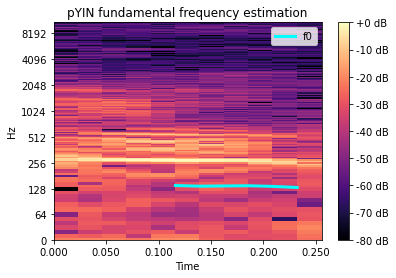

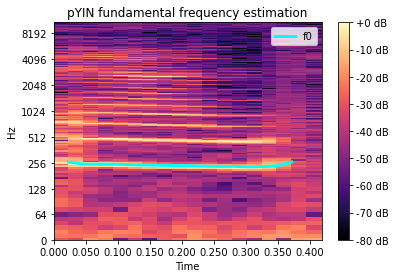

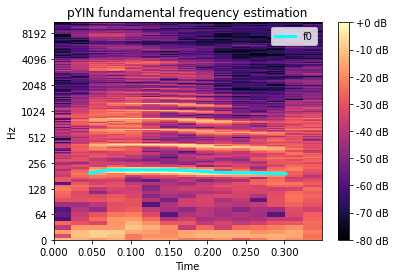

In [8]:
f0_list = []
path = "one word/"
for audio_file in os.listdir(path): 
    print(audio_file)
    audio, sr = librosa.load(f"{path}{audio_file}", sr=SAMPLING_RATE)
    f0, _, _ = librosa.pyin(audio, fmin=50, fmax=500)
    times = librosa.times_like(f0)
    
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
    ax.set(title='pYIN fundamental frequency estimation')
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
    ax.legend(loc='upper right')
    


[304.89940465 296.21951046 291.13063657 291.13063657 287.786716
 286.12918649 286.12918649 277.98364397 263.90158215 277.98364397
 274.79072949 273.20805135 273.20805135 273.20805135 276.38257599
 274.79072949 268.51450056 270.06998923 247.65527208 251.98420998
 253.44393966 253.44393966 251.98420998 251.98420998 251.98420998
 251.98420998 250.53288772 249.08992447 247.65527208 246.22888267
 247.65527208 246.22888267 246.22888267 246.22888267 244.81070866
 241.99881784 237.841423   244.81070866 241.99881784 239.21922435
 239.21922435 239.21922435 240.60500722 240.60500722 265.43034847
 268.51450056 270.06998923 266.96797083 263.90158215 259.36791093
 254.91212546 254.91212546 254.91212546 251.98420998 251.98420998
 249.08992447 246.22888267 243.40070273 241.99881784 240.60500722
 240.60500722 240.60500722 239.21922435 236.47155721 246.22888267
 247.65527208 246.22888267 244.81070866 243.40070273 241.99881784
 243.40070273 251.98420998 256.38881638]


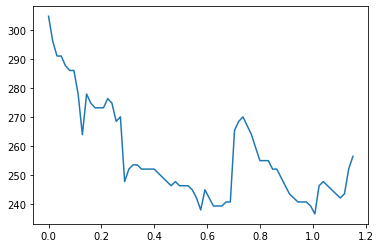

In [100]:
print(f0_list[0])
first = f0_list[0]
times = librosa.times_like(first, sr=SAMPLING_RATE, hop_length=HOP_LENGTH)
plt.plot(times, first)


# Plot segmented audio

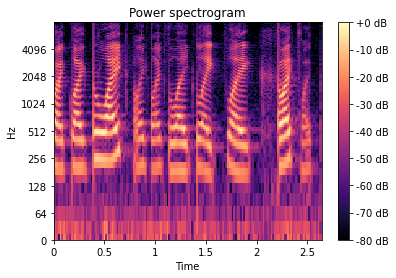

In [10]:
audio, sr = librosa.load(f"{SEGMENTED_PATH}345_AUDIO_SLICED_30.0s_word-LIKE.wav", sr=SAMPLING_RATE)
S_audio = librosa.stft(audio, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(S_audio),ref=np.max),y_axis='log', x_axis='time', ax=ax, hop_length=HOP_LENGTH, sr=SAMPLING_RATE)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")
